<div style="text-align: right">Author: Yuktha Bhadane (yb294@cornell.edu)</div>

### Phase Out Order: Country Map
This notebook creates spatial visualizations of power plant phaseout scenarios for eight developing countries (India, Indonesia, South Africa, Mexico, Vietnam, Iran, Thailand, and Egypt), mapping the geographical distribution of plants and their scheduled phase-out years; comparing different phaseout criteria as a country map with state lines.

0. Set Up

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.lines import Line2D
from pathlib import Path

1. Country-specific Layout Settings

*(I did these by looking at the map and then some trial-error. If you have a better method, I am open.)*

In [4]:
layout_settings = {
   'IND': {
       'colorbar': {'x': 0.75, 'y': 0.22, 'width': 0.02, 'height': 0.2},
       'legend': {'x': 0.7, 'y': 0.45},
       'note': {'x': 0.5, 'y': 0.05}
   },
   'IDN': {
       'colorbar': {'x': 0.065, 'y': 0.33, 'width': 0.018, 'height': 0.14},
       'legend': {'x': 1, 'y': 0.95},
       'note': {'x': 0.5, 'y': 0.67}
   },
   'MEX': {
       'colorbar': {'x': 0.07, 'y': 0.33, 'width': 0.018, 'height': 0.2},
       'legend': {'x': 1, 'y': 0.97},
       'note': {'x': 0.5, 'y': 0.79}
   },
   'EGY': {
       'colorbar': {'x': 0.2, 'y': 0.33, 'width': 0.018, 'height': 0.2},
       'legend': {'x': 1, 'y': 0.97},
       'note': {'x': 0.5, 'y': 0.03}
   },
   'THA': {
       'colorbar': {'x': 0.67, 'y': 0.23, 'width': 0.018, 'height': 0.2},
       'legend': {'x': 1, 'y': 0.97},
       'note': {'x': 0.635, 'y': 0.02}
   },
   'ZAF': {
       'colorbar': {'x': 0.9, 'y': 0.1, 'width': 0.02, 'height': 0.25},
       'legend': {'x': 0.12, 'y': 0.97},
       'note': {'x': 0.5, 'y': 0.1}
   },
   'VNM': {
       'colorbar': {'x': 0.35, 'y': 0.35, 'width': 0.018, 'height': 0.25},
       'legend': {'x': 1, 'y': 1},
       'note': {'x': 0.5, 'y': 0.02}
   },
   'IRN': {
       'colorbar': {'x': 0.1, 'y': 0.15, 'width': 0.018, 'height': 0.25},
       'legend': {'x': 1, 'y': 1},
       'note': {'x': 0.5, 'y': 0.08}
   }
}

2. Data Loading & Processing

In [19]:
def load_merge_data(phase_file, country_iso3):
    """
    Load and merge phaseout data with Forward Analytics plant location data.
    
    Parameters:
    phase_file (str): Path to phaseout CSV file
    country_iso3 (str): Three-letter ISO country code
    
    Returns:
    pandas.DataFrame: Merged dataset with plant locations and phaseout information
    """
    # Load phaseout data
    df_phase = pd.read_csv(phase_file)
    
    # Load Forward Analytics dataset with plant locations
    # Using absolute path with comment for GitHub users
    df_forward = pd.read_csv('/Users/yukthabhadane/Documents/Climate Finance Thesis/Data/v3_power_Forward_Analytics2024.csv', low_memory=False)
    # For GitHub users:
    # df_forward = pd.read_csv('data/v3_power_Forward_Analytics2024.csv', low_memory=False)
    
    # Filter for the specific country
    df_forward_country = df_forward[df_forward['countryiso3'] == country_iso3]
    
    # Merge datasets
    df_merged = df_phase.merge(
        df_forward_country[['asset_name', 'uniqueforwardassetid', 'latitude', 'longitude']], 
        on=['asset_name', 'uniqueforwardassetid'],
        how='left'
    )
    
    # Add jitter to prevent point overlap
    np.random.seed(42)
    jitter_scale = 0.03
    df_merged['longitude'] = df_merged['longitude'] + np.random.normal(0, jitter_scale, len(df_merged))
    df_merged['latitude'] = df_merged['latitude'] + np.random.normal(0, jitter_scale, len(df_merged))
    
    return df_merged

def create_phaseout_map(df_merged, title, country_iso3, method_key, save=False):
    """
    Create a map visualization for a country's power plant phaseout schedule.
    
    Parameters:
    df_merged (pandas.DataFrame): Merged dataset with plant locations and phaseout information
    title (str): Title for the map
    country_iso3 (str): Three-letter ISO country code
    method_key (str): Key identifying the phaseout method
    save (bool): Whether to save the figure to a file
    """
    # Load country shapefile
    # Using absolute path with comment for GitHub users
    shapefile_path = f'/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Shape Files/gadm41_{country_iso3}_shp/gadm41_{country_iso3}_1.shp'
    # For GitHub users: https://gadm.org/download_country.html 
    
    country = gpd.read_file(shapefile_path)

    # Create figure and plot country boundary
    fig, ax = plt.subplots(figsize=(15, 15))
    country.plot(ax=ax, color='white', edgecolor='grey')

    # Set marker shapes for different fuel types
    markers = {'Coal': 'o', 'Oil': 's', 'Gas': '^'}
    legend_color = 'dimgray'  # Using a neutral gray for legend
    
    # Create custom legend elements with grayscale markers
    legend_elements = []
    for subsector, marker in markers.items():
        legend_elements.append(
            Line2D([0], [0], marker=marker, color='w', 
                  markerfacecolor=legend_color, markeredgecolor='black',
                  markersize=10, label=subsector)
        )

    # Scale marker sizes based on emissions
    sizes = df_merged['amount_mtco2'].clip(lower=0.1) * 100

    # Plot each fuel type with distinct markers
    for subsector in markers.keys():
        if subsector in df_merged['subsector'].unique():
            mask = df_merged['subsector'] == subsector
            scatter = ax.scatter(
                df_merged[mask]['longitude'], 
                df_merged[mask]['latitude'],
                c=df_merged[mask]['year'],
                cmap='YlOrRd',
                marker=markers[subsector],
                s=sizes[mask],
                alpha=0.7,
                vmin=2025,
                vmax=2050
            )

    # Get country-specific layout settings
    settings = layout_settings[country_iso3]
    
    # Add colorbar
    cax = fig.add_axes([
        settings['colorbar']['x'],
        settings['colorbar']['y'],
        settings['colorbar']['width'],
        settings['colorbar']['height']
    ])
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.ax.set_title('Phase-out Year', fontsize=14, pad=10)
    cbar.ax.tick_params(labelsize=14, direction='out')
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')

    # Add legend for fuel types
    leg = ax.legend(handles=legend_elements, title='Fuel Type', 
                   bbox_to_anchor=(settings['legend']['x'], settings['legend']['y']),
                   fontsize=16, title_fontsize=14)

    # Add note about marker size
    plt.figtext(settings['note']['x'], settings['note']['y'],
               'Note: Marker size proportional to emissions',
               fontsize=12, ha='center')

    # Set map bounds with padding
    padding = 0.2
    ax.set_xlim([country.total_bounds[0]-padding, country.total_bounds[2]+padding])
    ax.set_ylim([country.total_bounds[1]-padding, country.total_bounds[3]+padding])
    
    # Set title and remove axis ticks
    ax.set_title(title, pad=20, fontsize=26, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    
    if save:
        # Create output directory in same folder as notebook
        output_dir = 'phase_out_order_maps'
        os.makedirs(output_dir, exist_ok=True)
        
        # Save figure
        output_file = f'{output_dir}/{country_iso3}_{method_key}_map.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Map saved to {output_file}")

        plt.close(fig)
    return fig

3. Execution

In [20]:
# ISO code mapping (two-letter to three-letter)
iso_mapping = {
   'IN': 'IND', 'ID': 'IDN', 'ZA': 'ZAF', 'MX': 'MEX',
   'VN': 'VNM', 'IR': 'IRN', 'TH': 'THA', 'EG': 'EGY'
}

# Method definitions with display titles
methods = {
    'maturity': 'By Power Plant Maturity',
    'emission_factor': 'By Power Plant Emission Intensity',
    'emissions_per_OC_maturity': 'By Power Plant Benefits/Costs (Including Plant Maturity)'
}

# File name patterns for each method
file_patterns = {
    'maturity': 'v2_power_plant_phaseout_order_by_maturity_{}_2050.csv',
    'emission_factor': 'v2_power_plant_phaseout_order_by_emission_factor_{}_2050.csv',
    'emissions_per_OC_maturity': 'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_{}_2050.csv'
}

# Data directory path
# Note: Update these paths to local or relative paths for GitHub
# Using absolute path with comment for GitHub users
base_path = '/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data/'


4. Example: Running for India

/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


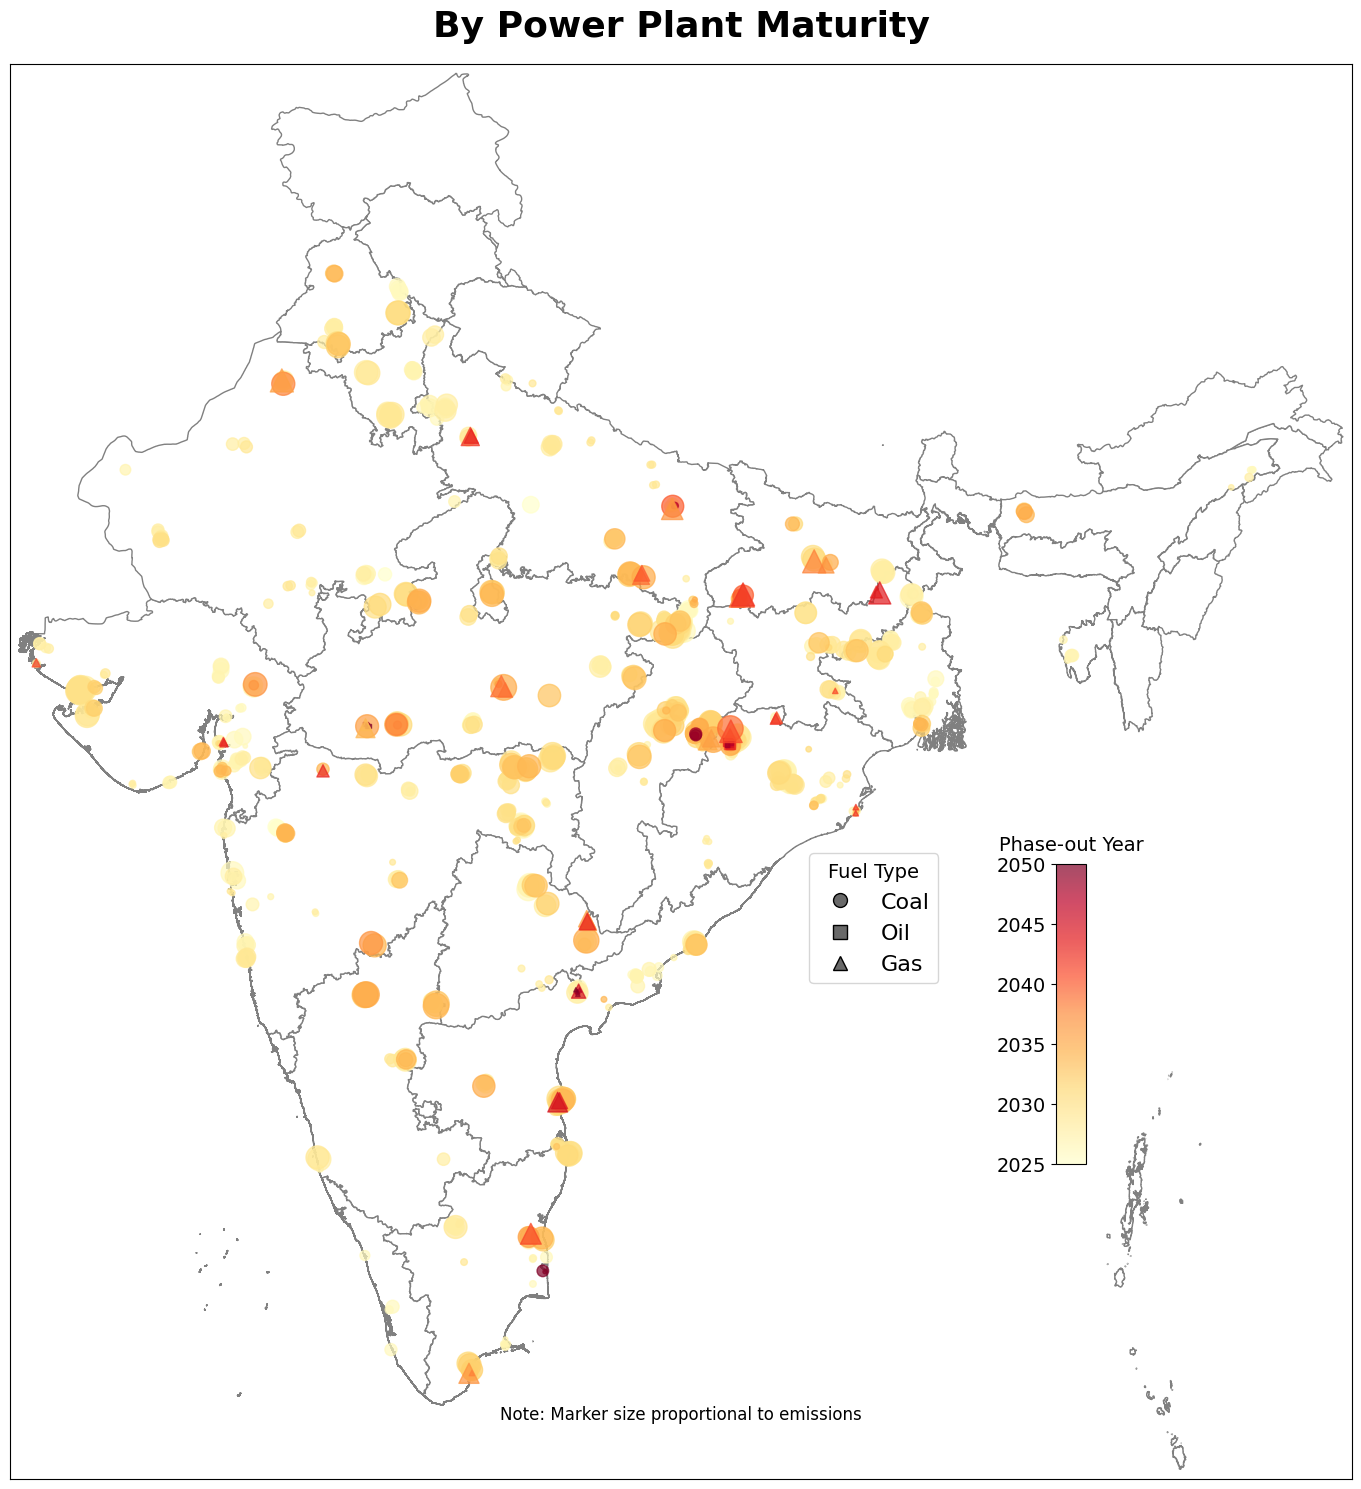

In [21]:
country_code = 'IN'
country_iso3 = 'IND'
method_key = 'maturity'
title = methods[method_key]
file = file_patterns[method_key].format(country_code)
file_path = base_path + file
if os.path.exists(file_path):
    df_merged = load_merge_data(file_path, country_iso3)
    fig = create_phaseout_map(df_merged, title, country_iso3, method_key, save=False)
    plt.show()
else:
    print(f"File not found: {file_path}")

5. Generate Maps for All Countries

In [22]:
for country_code, country_iso3 in iso_mapping.items():
    print(f"\nProcessing maps for {country_iso3}...")
    for method_key, title in methods.items():
        file = file_patterns[method_key].format(country_code)
        file_path = base_path + file
        if os.path.exists(file_path):
            print(f"  Creating map for {method_key} method...")
            df_merged = load_merge_data(file_path, country_iso3)
            create_phaseout_map(df_merged, title, country_iso3, method_key, save=True)  # Set save=True here
        else:
            print(f"  File not found: {file_path}")

print("\nAll maps generated successfully!")


Processing maps for IND...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IND_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IND_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IND_emissions_per_OC_maturity_map.png

Processing maps for IDN...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IDN_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IDN_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IDN_emissions_per_OC_maturity_map.png

Processing maps for ZAF...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/ZAF_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/ZAF_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/ZAF_emissions_per_OC_maturity_map.png

Processing maps for MEX...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/MEX_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/MEX_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/MEX_emissions_per_OC_maturity_map.png

Processing maps for VNM...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/VNM_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/VNM_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/VNM_emissions_per_OC_maturity_map.png

Processing maps for IRN...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IRN_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IRN_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/IRN_emissions_per_OC_maturity_map.png

Processing maps for THA...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/THA_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/THA_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/THA_emissions_per_OC_maturity_map.png

Processing maps for EGY...
  Creating map for maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/EGY_maturity_map.png
  Creating map for emission_factor method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/EGY_emission_factor_map.png
  Creating map for emissions_per_OC_maturity method...


/var/folders/n_/wz0dpmns379dn5s9v5qcpxww0000gn/T/ipykernel_22361/1761306678.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Map saved to phase_out_order_maps/EGY_emissions_per_OC_maturity_map.png

All maps generated successfully!
